In [33]:
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Preprocessing:

In [34]:
# Initialize an empty list to store DataFrames
dataframes = []

# Iterate over all files matching the pattern
for file in glob.glob("../subject-*.csv"):
    if "recall" in file or "Recall" in file:
        continue
    # Read the CSV file into a DataFrame
    temp_df = pd.read_csv(file)
    
    # Extract the subject number from the filename
    subject_number = os.path.basename(file).split('-')[1].split('.')[0]
    
    # Add a new column for the subject number
    temp_df['subject_number'] = subject_number
    
    # Append the DataFrame to the list
    dataframes.append(temp_df)

# Concatenate all DataFrames into a single DataFrame
all_data = pd.concat(dataframes, ignore_index=True)

# Display the resulting DataFrame
# print(all_data)

In [35]:
# Remove rows where 'trial' is not numeric
all_data = all_data[pd.to_numeric(all_data['trial'], errors='coerce').notnull()]

# Remove rows where 'rt' is 'inf'
all_data = all_data[all_data['rt'] != 'inf']

# Convert 'rt', 'start_time', 'time_bar', 'expected_rt', and 'alpha' to numeric, coercing errors to NaN
all_data['rt'] = pd.to_numeric(all_data['rt'], errors='coerce')
all_data['start_time'] = pd.to_numeric(all_data['start_time'], errors='coerce')
all_data['time_bar'] = pd.to_numeric(all_data['time_bar'], errors='coerce')
all_data['expected_rt'] = pd.to_numeric(all_data['expected_rt'], errors='coerce')
all_data['alpha'] = pd.to_numeric(all_data['alpha'], errors='coerce')
all_data['subject_number'] = pd.to_numeric(all_data['subject_number'], errors='coerce')
all_data['trial'] = pd.to_numeric(all_data['trial'], errors='coerce')
all_data['fact_id'] = pd.to_numeric(all_data['fact_id'], errors='coerce')

# Convert columns with 'True' and 'False' strings to boolean values
bool_columns = ['new', 'on_time', 'time_bar_visible', 'correct']
for col in bool_columns:
    all_data[col] = all_data[col].map({'True': True, 'False': False})

# Apply log transformation to 'rt' 
all_data['log_rt'] = np.log(all_data['rt'])

# Filter the DataFrame to include only rows where 'new' is False
filtered_data = all_data[all_data['new'] == False]

In [36]:
# Group by 'subject_number' and extract 'question', 'answer', and 'time_bar_visible'
subject_words = all_data.groupby('subject_number')[['question', 'answer', 'time_bar_visible']].apply(lambda x: x.reset_index(drop=True))

# Reset the index to include 'subject_number' in the CSV
subject_words = subject_words.reset_index()

# Drop duplicate rows to ensure unique combinations
subject_words = subject_words.drop_duplicates(subset=['question', 'answer', 'time_bar_visible', 'subject_number'])

# Display the resulting DataFrame
# print(subject_words)

subject_words.to_csv('subject_words_timebar.csv', index=False)

# Boxplot of reaction time and log transformed reaction time over all trials:

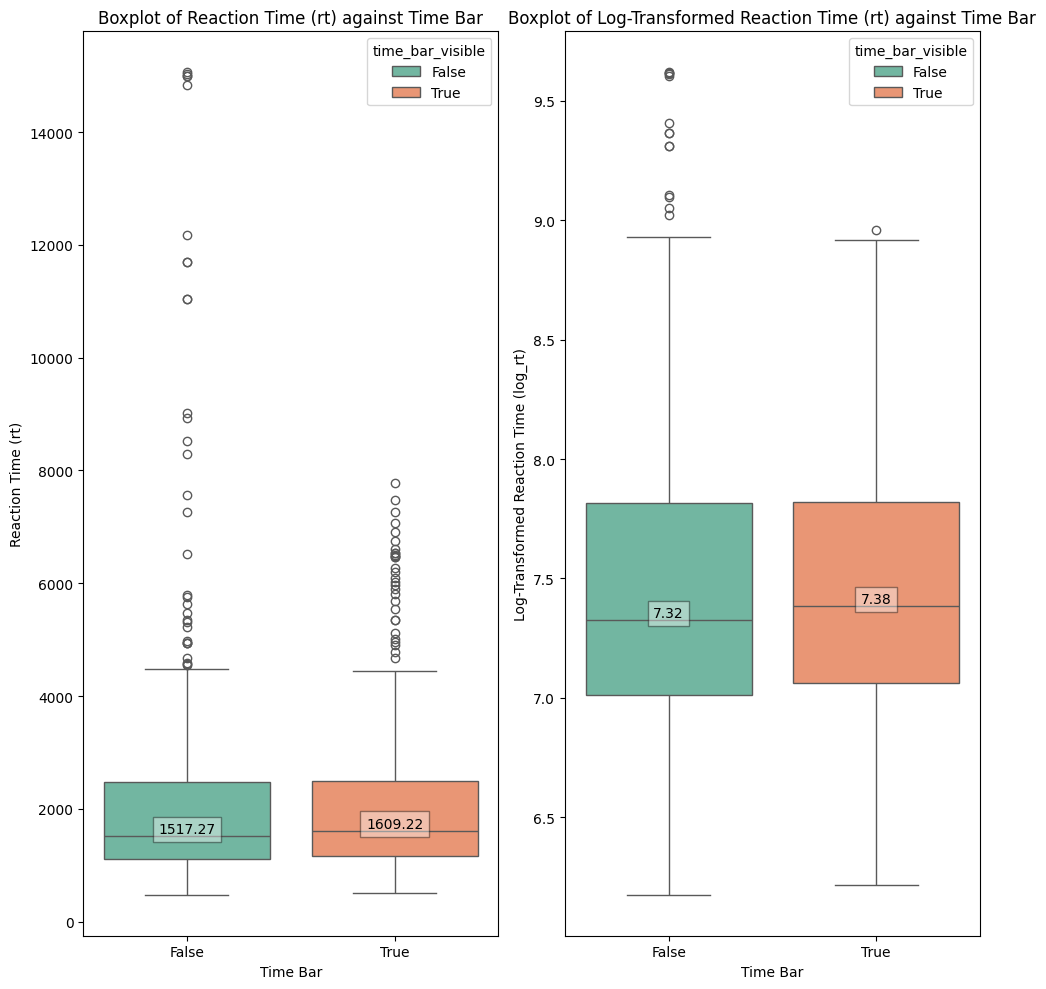

In [37]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

# Create the first boxplot
sns.boxplot(ax=axes[0], x='time_bar_visible', y='rt', data=filtered_data, palette='Set2', hue='time_bar_visible')
axes[0].set_title('Boxplot of Reaction Time (rt) against Time Bar')
axes[0].set_xlabel('Time Bar')
axes[0].set_ylabel('Reaction Time (rt)')

# Calculate and annotate the medians for 'rt'
medians_rt = filtered_data.groupby('time_bar_visible')['rt'].median()
for i, median in enumerate(medians_rt):
    axes[0].text(i, median, f'{median:.2f}', ha='center', va='bottom', color='black', bbox=dict(facecolor='white', alpha=0.4))

# Create the second boxplot with log-transformed 'rt'
sns.boxplot(ax=axes[1], x='time_bar_visible', y='log_rt', data=filtered_data, palette='Set2', hue='time_bar_visible')
axes[1].set_title('Boxplot of Log-Transformed Reaction Time (rt) against Time Bar')
axes[1].set_xlabel('Time Bar')
axes[1].set_ylabel('Log-Transformed Reaction Time (log_rt)')

# Calculate and annotate the medians for 'log_rt'
medians_log_rt = filtered_data.groupby('time_bar_visible')['log_rt'].median()
for i, median in enumerate(medians_log_rt):
    axes[1].text(i, median, f'{median:.2f}', ha='center', va='bottom', color='black', bbox=dict(facecolor='white', alpha=0.4))

# Show the plots
plt.tight_layout()
plt.show()

# Distributions of reaction times

### not sure if this is needed

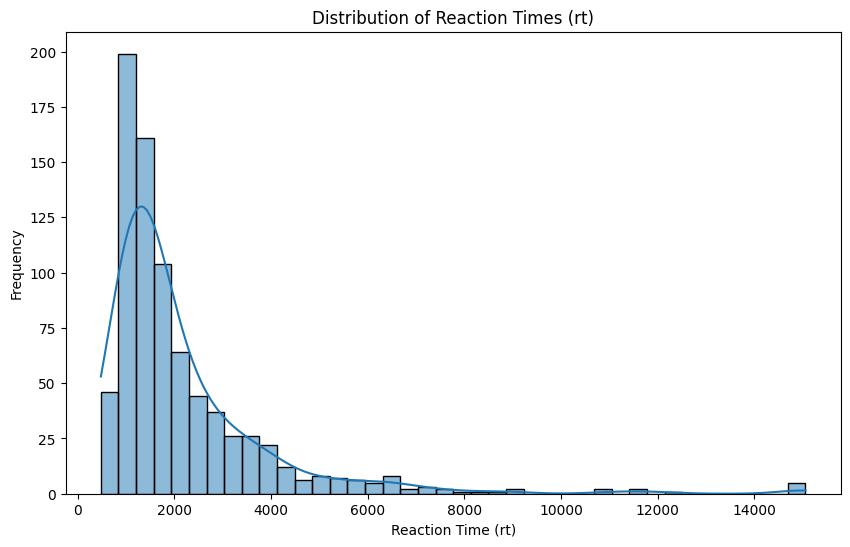

In [38]:
# Create a distribution plot for the reaction times (rt)
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['rt'], bins=40, kde=True)
plt.title('Distribution of Reaction Times (rt)')
plt.xlabel('Reaction Time (rt)')
plt.ylabel('Frequency')
plt.show()

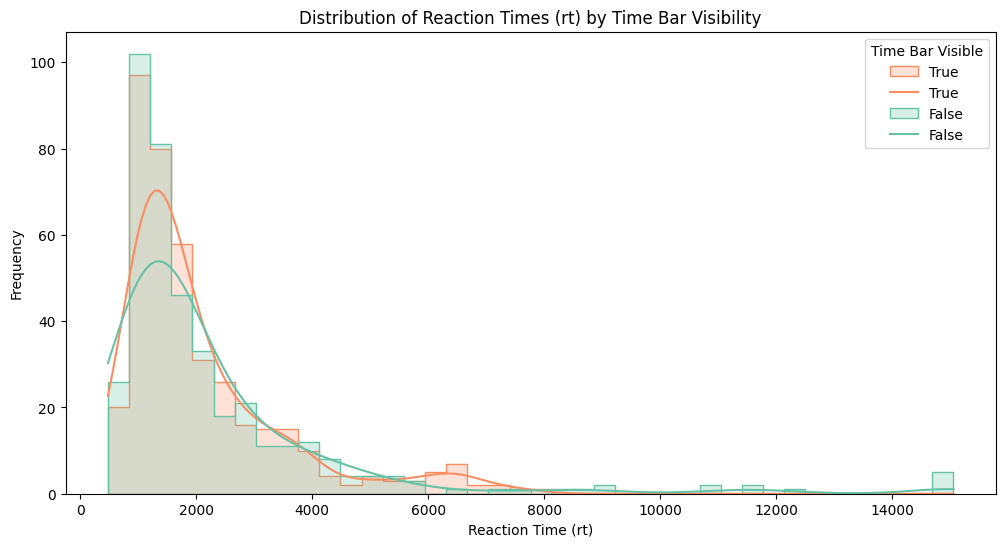

In [39]:
plt.figure(figsize=(12, 6))
ax = sns.histplot(data=filtered_data, x='rt', hue='time_bar_visible', bins=40, kde=True, element='step', palette='Set2')
plt.title('Distribution of Reaction Times (rt) by Time Bar Visibility')
plt.xlabel('Reaction Time (rt)')
plt.ylabel('Frequency')
ax.legend(title='Time Bar Visible', labels=['True', 'True', 'False', 'False'])
plt.show()

# The following data is first averaged for each subject:

In [40]:
# Group by 'subject_number' and 'time_bar_visible' and calculate additional statistics
evals = filtered_data.groupby(['subject_number', 'time_bar_visible']).agg(
    accuracy=('correct', 'mean'),
    mean_rt=('rt', 'mean'),
    std_rt=('rt', 'std'),
    median_rt=('rt', 'median'),
    mean_expected_rt=('expected_rt', 'mean'),
    percentage_on_time=('on_time', lambda x: (x.sum() / len(x)) * 100),
    unique_fact_id=('fact_id', 'nunique'),
    trial_count=('trial', 'count')
).reset_index()

# Display the eval DataFrame with additional statistics
# print(evals)

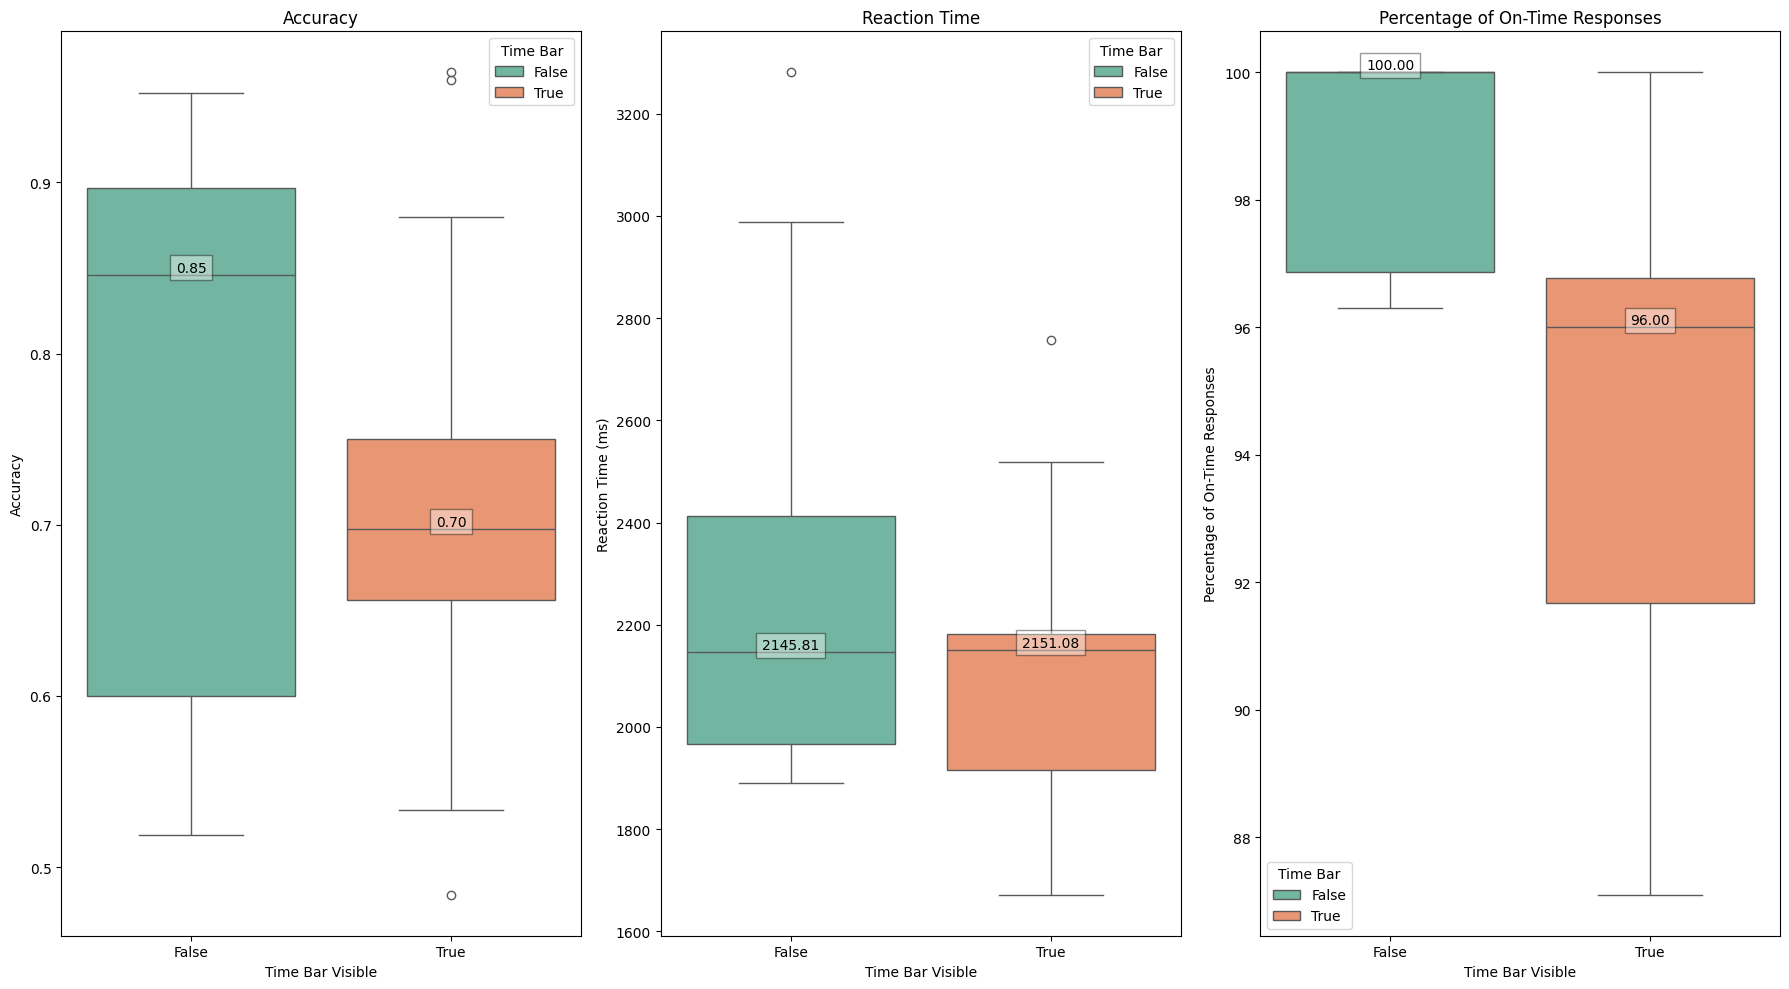

In [41]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 10))

# Plot accuracy
sns.boxplot(ax=axes[0], x='time_bar_visible', y='accuracy', data=evals, palette='Set2', hue='time_bar_visible')
axes[0].set_title('Accuracy')
axes[0].set_xlabel('Time Bar Visible')
axes[0].set_ylabel('Accuracy')
axes[0].legend(title='Time Bar')

# Calculate and annotate the medians for 'accuracy'
medians_accuracy = evals.groupby('time_bar_visible')['accuracy'].median()
for i, median in enumerate(medians_accuracy):
    axes[0].text(i, median, f'{median:.2f}', ha='center', va='bottom', color='black', bbox=dict(facecolor='white', alpha=0.4))

# Plot mean reaction time
sns.boxplot(ax=axes[1], x='time_bar_visible', y='mean_rt', data=evals, palette='Set2', hue='time_bar_visible')
axes[1].set_title('Reaction Time')
axes[1].set_xlabel('Time Bar Visible')
axes[1].set_ylabel('Reaction Time (ms)')
axes[1].legend(title='Time Bar')

# Calculate and annotate the medians for 'mean_rt'
medians_mean_rt = evals.groupby('time_bar_visible')['mean_rt'].median()
for i, median in enumerate(medians_mean_rt):
    axes[1].text(i, median, f'{median:.2f}', ha='center', va='bottom', color='black', bbox=dict(facecolor='white', alpha=0.4))

# Plot percentage of on-time responses
sns.boxplot(ax=axes[2], x='time_bar_visible', y='percentage_on_time', data=evals, palette='Set2', hue='time_bar_visible')
axes[2].set_title('Percentage of On-Time Responses')
axes[2].set_xlabel('Time Bar Visible')
axes[2].set_ylabel('Percentage of On-Time Responses')
axes[2].legend(title='Time Bar')

# Calculate and annotate the medians for 'percentage_on_time'
medians_on_time = evals.groupby('time_bar_visible')['percentage_on_time'].median()
for i, median in enumerate(medians_on_time):
    axes[2].text(i, median, f'{median:.2f}', ha='center', va='bottom', color='black', bbox=dict(facecolor='white', alpha=0.4))

# Show the plots
plt.tight_layout()
plt.show()

# The following plot simply takes the accuracy and mean reaction time of all trials:

If you want to show only the results for 1 participants, uncomment the following code:

In [42]:
# Filter the DataFrame to include only rows where 'subject_number' is X
# filtered_data = filtered_data[filtered_data['subject_number'] == 3]

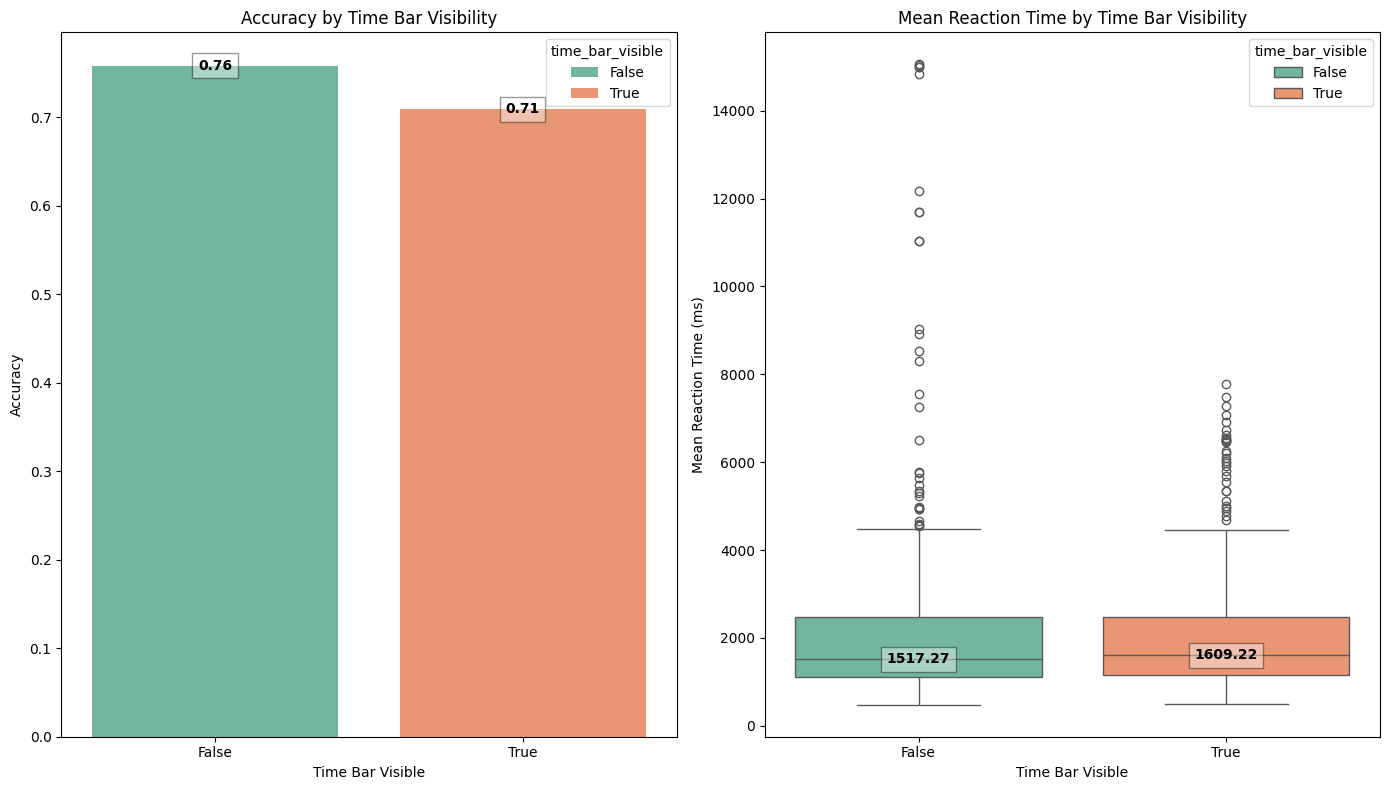

In [43]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# Plot accuracy as a barplot
sns.barplot(ax=axes[0], x='time_bar_visible', y='correct', data=filtered_data, palette='Set2', hue='time_bar_visible', errorbar=None)
axes[0].set_title('Accuracy by Time Bar Visibility')
axes[0].set_xlabel('Time Bar Visible')
axes[0].set_ylabel('Accuracy')

# Calculate and add median values for accuracy
median_accuracy = filtered_data.groupby('time_bar_visible')['correct'].mean()
for i, median in enumerate(median_accuracy):
    axes[0].text(i, median, f'{median:.2f}', ha='center', va='center', color='black', fontweight='bold', bbox=dict(facecolor='white', alpha=0.4))

# Plot mean reaction time
sns.boxplot(ax=axes[1], x='time_bar_visible', y='rt', data=filtered_data, palette='Set2', hue='time_bar_visible')
axes[1].set_title('Mean Reaction Time by Time Bar Visibility')
axes[1].set_xlabel('Time Bar Visible')
axes[1].set_ylabel('Mean Reaction Time (ms)')

# Calculate and add median values for mean reaction time
median_rt = filtered_data.groupby('time_bar_visible')['rt'].median()
for i, median in enumerate(median_rt):
    axes[1].text(i, median, f'{median:.2f}', ha='center', va='center', color='black', fontweight='bold', bbox=dict(facecolor='white', alpha=0.4))

# Show the plots
plt.tight_layout()
plt.show()

# Some T-tests, first, the accuracy, mean, percentage on time is calculated per subject:

In [44]:
from scipy.stats import ttest_ind

# Separate the data based on time_bar_visible condition
accuracy_false = evals[evals['time_bar_visible'] == False]['accuracy']
accuracy_true = evals[evals['time_bar_visible'] == True]['accuracy']

mean_rt_false = evals[evals['time_bar_visible'] == False]['mean_rt']
mean_rt_true = evals[evals['time_bar_visible'] == True]['mean_rt']

on_time_false = evals[evals['time_bar_visible'] == False]['percentage_on_time']
on_time_true = evals[evals['time_bar_visible'] == True]['percentage_on_time']

# Perform t-tests
t_stat_accuracy, p_value_accuracy = ttest_ind(accuracy_false, accuracy_true)
t_stat_mean_rt, p_value_mean_rt = ttest_ind(mean_rt_false, mean_rt_true)
t_stat_on_time, p_value_on_time = ttest_ind(on_time_false, on_time_true)

# Print the results
print(f"Accuracy t-test: t-statistic = {t_stat_accuracy}, p-value = {p_value_accuracy}")
print(f"Mean Reaction Time t-test: t-statistic = {t_stat_mean_rt}, p-value = {p_value_mean_rt}")
print(f"On-Time Percentage t-test: t-statistic = {t_stat_on_time}, p-value = {p_value_on_time}")

Accuracy t-test: t-statistic = 0.9775412105984222, p-value = 0.3380526833490416
Mean Reaction Time t-test: t-statistic = 1.1732616321198586, p-value = 0.2522039281060037
On-Time Percentage t-test: t-statistic = 3.168994850667218, p-value = 0.004139654152300792


# T-test over all trials

In [45]:

# Separate the data based on time_bar_visible condition
accuracy_false_full = filtered_data[filtered_data['time_bar_visible'] == False]['correct']
accuracy_true_full = filtered_data[filtered_data['time_bar_visible'] == True]['correct']

mean_rt_false_full = filtered_data[filtered_data['time_bar_visible'] == False]['rt']
mean_rt_true_full = filtered_data[filtered_data['time_bar_visible'] == True]['rt']

on_time_false_full = filtered_data[filtered_data['time_bar_visible'] == False]['on_time']
on_time_true_full = filtered_data[filtered_data['time_bar_visible'] == True]['on_time']

# Perform t-tests
t_stat_accuracy_full, p_value_accuracy_full = ttest_ind(accuracy_false_full, accuracy_true_full)
t_stat_mean_rt_full, p_value_mean_rt_full = ttest_ind(mean_rt_false_full, mean_rt_true_full)
t_stat_on_time_full, p_value_on_time_full = ttest_ind(on_time_false_full, on_time_true_full)

# Print the results
print(f"Accuracy t-test (full data): t-statistic = {t_stat_accuracy_full}, p-value = {p_value_accuracy_full}")
print(f"Mean Reaction Time t-test (full data): t-statistic = {t_stat_mean_rt_full}, p-value = {p_value_mean_rt_full}")
print(f"On-Time Percentage t-test (full data): t-statistic = {t_stat_on_time_full}, p-value = {p_value_on_time_full}")

Accuracy t-test (full data): t-statistic = 1.5755350493709566, p-value = 0.11552784645427086
Mean Reaction Time t-test (full data): t-statistic = 1.30232116802309, p-value = 0.19318095233261837
On-Time Percentage t-test (full data): t-statistic = 3.19976181093153, p-value = 0.0014295723688719226


In [46]:
# Group by 'subject_number' and 'question' and count the occurrences
all_data['word_count'] = all_data.groupby(['subject_number', 'question'])['question'].transform('count')

# Display the updated DataFrame
print(all_data)

      trial   start_time         rt  correct      time_bar keyboard_response  \
0         1  118820.1344  4883.9366    False  15000.000000               NaN   
1         2  126047.0749  1646.0669     True   7217.064757         knowledge   
2         3  132362.3503  4523.2602    False  15000.000000               NaN   
3         4  139224.7193  1297.6233     True   6495.283300           glasses   
4         5  144304.7308  4968.4928    False  15000.000000               NaN   
...     ...          ...        ...      ...           ...               ...   
1207     51  588078.4941  1114.0807     True  15000.000000             knife   
1208     52  592615.3018  4982.5102    False  15000.000000              food   
1209     53  600546.7210  1967.8424     True  15000.000000             wheel   
1211     55  611235.3671  1410.8993     True  15000.000000              shop   
1212     56  615701.8947  3750.0103    False  15000.000000              food   

        new  on_time  expected_rt  time

In [48]:
# Group by 'subject_number' and 'question', then use cumcount to track the occurrences
filtered_data.loc[:, 'word_occurrence'] = filtered_data.groupby(['subject_number', 'question']).cumcount() + 1

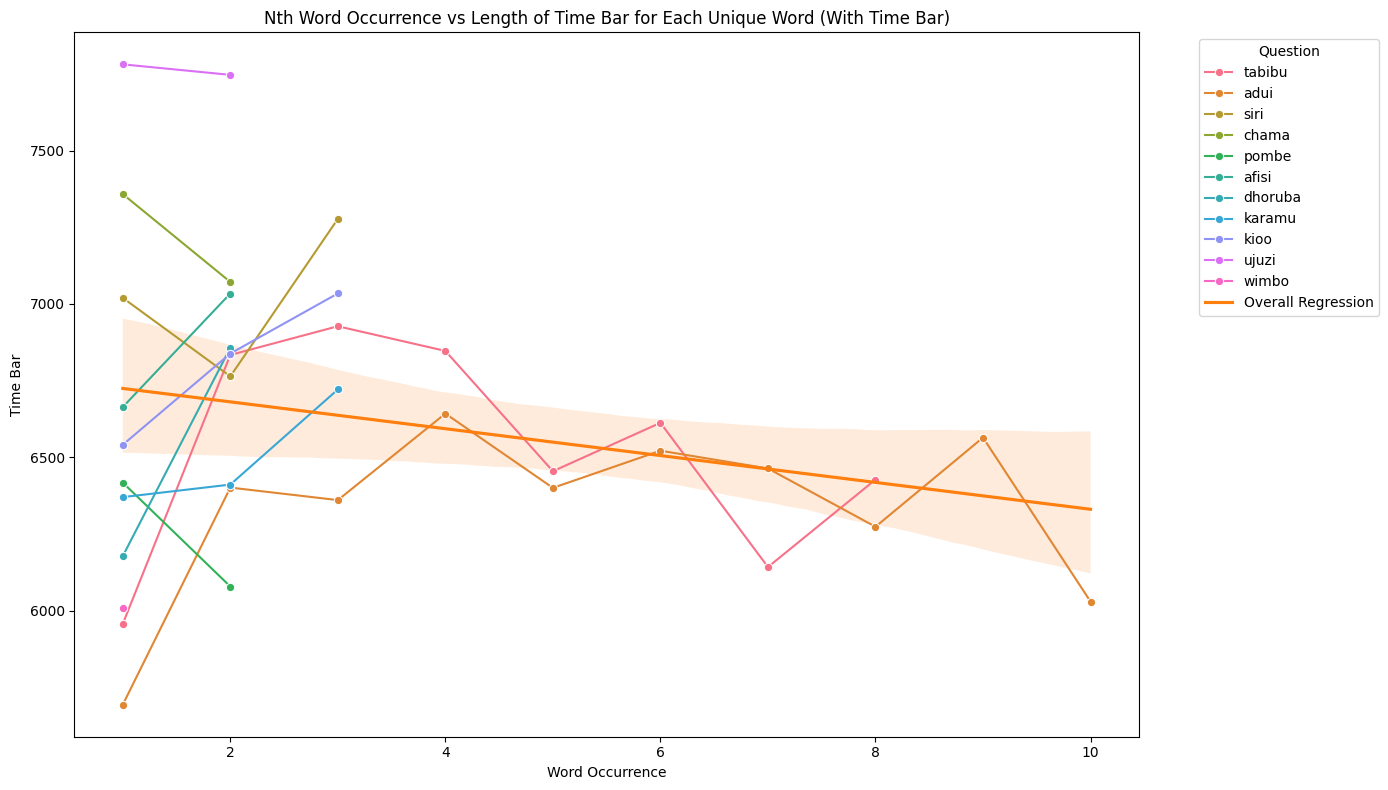

In [63]:
# Filter the data to include only rows where 'subject_number' is 10
filtered_data_participant_11 = filtered_data[filtered_data['subject_number'] == 10]

plt.figure(figsize=(14, 8))

# Filter the data to include only rows where 'time_bar_visible' is True
filtered_data_timebar_true = filtered_data_participant_11[filtered_data_participant_11['time_bar_visible'] == True]

# Plot word_occurrence against time_bar for each unique word
sns.lineplot(data=filtered_data_timebar_true, x='word_occurrence', y='time_bar', hue='question', marker='o')

# Add a single regression line for all data
sns.regplot(data=filtered_data_timebar_true, x='word_occurrence', y='time_bar', scatter=False, label='Overall Regression')

plt.title('Nth Word Occurrence vs Length of Time Bar for Each Unique Word (With Time Bar)')
plt.xlabel('Word Occurrence')
plt.ylabel('Time Bar')
plt.legend(title='Question', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


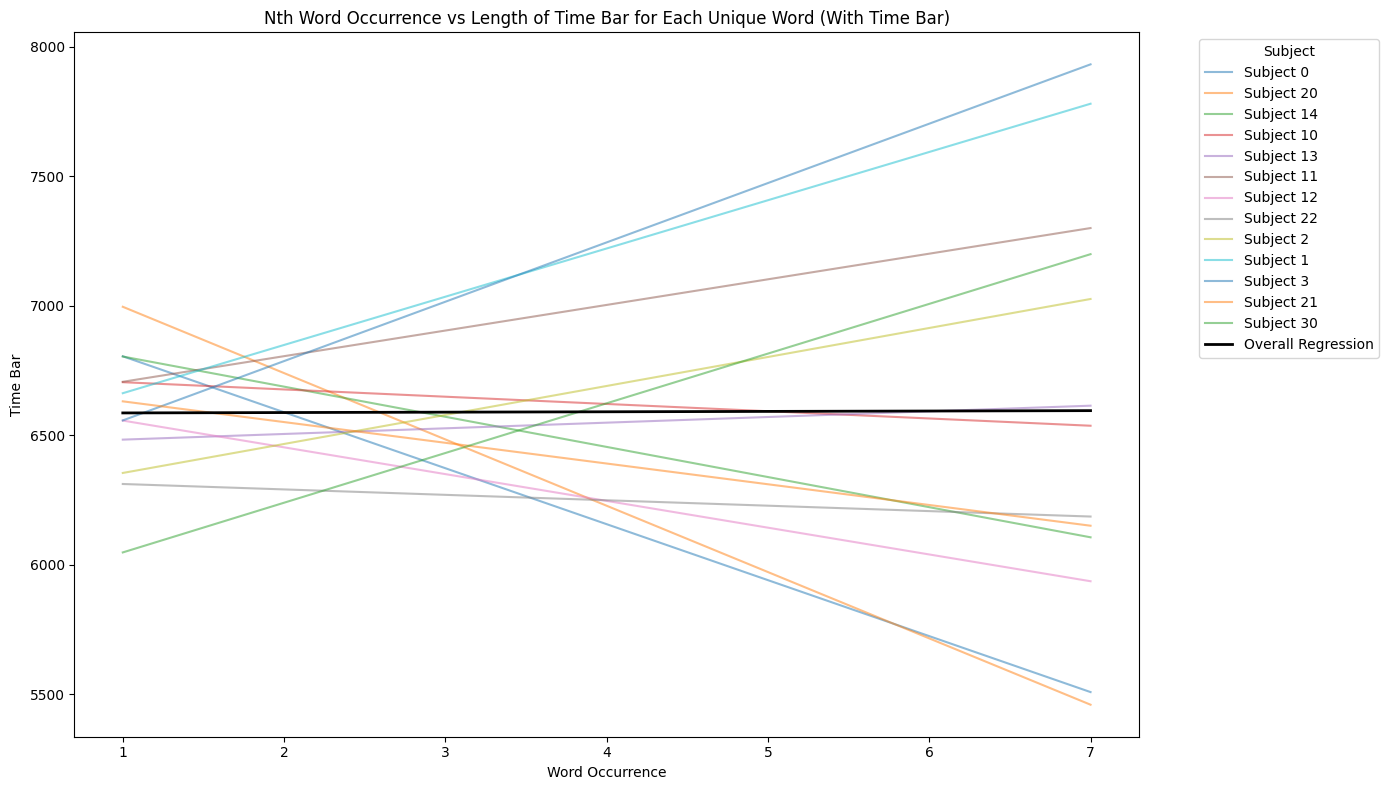

In [60]:
from sklearn.linear_model import LinearRegression

# Initialize a dictionary to store regression coefficients for each subject
regression_coeffs = {}

# Iterate over each unique subject
for subject in filtered_data['subject_number'].unique():
    # Filter data for the current subject
    subject_data = filtered_data[filtered_data['subject_number'] == subject]
    
    # Filter data where time_bar_visible is True and word_occurrence is less than or equal to 6
    subject_data = subject_data[(subject_data['time_bar_visible'] == True) & (subject_data['word_occurrence'] <= 7)]
    
    # Prepare the data for regression
    X = subject_data['word_occurrence'].values.reshape(-1, 1)
    y = subject_data['time_bar'].values
    
    # Perform linear regression
    reg = LinearRegression().fit(X, y)
    
    # Store the coefficients
    regression_coeffs[subject] = (reg.coef_[0], reg.intercept_)

# Plot the regression lines for each subject
plt.figure(figsize=(14, 8))
for subject, (coef, intercept) in regression_coeffs.items():
    x_vals = np.array(range(1, 8))  # Only up to 6 occurrences
    y_vals = coef * x_vals + intercept
    plt.plot(x_vals, y_vals, label=f'Subject {subject}', alpha=0.5)

# Calculate the overall regression line of the regression lines
overall_coef = np.mean([coef for coef, _ in regression_coeffs.values()])
overall_intercept = np.mean([intercept for _, intercept in regression_coeffs.values()])

# Plot the overall regression line
overall_x_vals = np.array(range(1, 8))  # Only up to 6 occurrences
overall_y_vals = overall_coef * overall_x_vals + overall_intercept
plt.plot(overall_x_vals, overall_y_vals, label='Overall Regression', color='black', linewidth=2)

plt.title('Nth Word Occurrence vs Length of Time Bar for Each Unique Word (With Time Bar)')
plt.xlabel('Word Occurrence')
plt.ylabel('Time Bar')
plt.legend(title='Subject', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


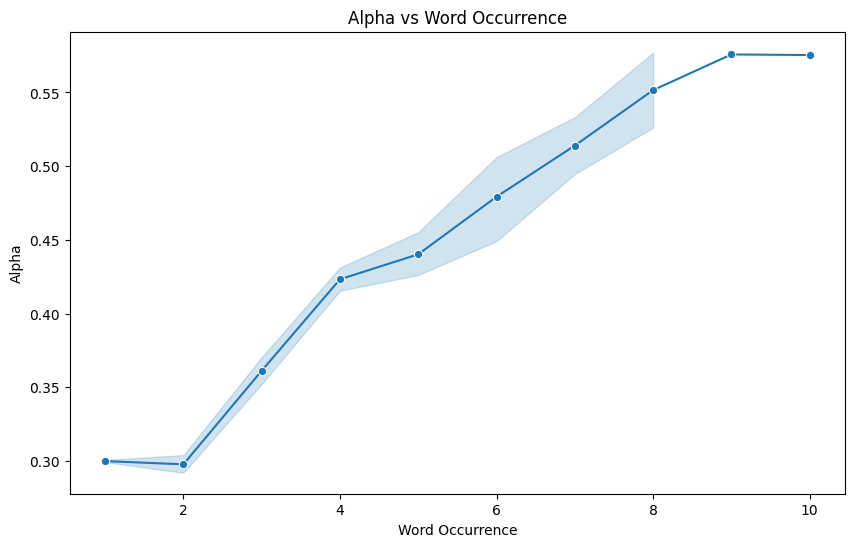

In [59]:
plt.figure(figsize=(10, 6))

# Plot alpha against word_occurrence
sns.lineplot(data=filtered_data, x='word_occurrence', y='alpha', marker='o')

plt.title('Alpha vs Word Occurrence')
plt.xlabel('Word Occurrence')
plt.ylabel('Alpha')
plt.show()